In [2]:
import os

DATASET = "detection/VehicleDamage"
REPO_PATH = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")),)
print(REPO_PATH)

/home/maxlaptop/Documents/Vehicle-Damage-Localisation


In [3]:
import torch
from hydra.utils import instantiate

import hydra
import sys
import os

import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

sys.path.append(REPO_PATH)
os.chdir(REPO_PATH)

In [4]:
import wandb

wandb.init(mode="disabled")

try:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
except:
    pass

hydra.initialize(version_base="1.2", config_path="../../src/")
cfg = hydra.compose(
    "main.yaml",
    overrides=[
        "+data=data",
        f"+data/dataset={DATASET}",
    ],
)

print(cfg)
device = torch.device("cpu")
data = instantiate(cfg.data, device=device, model_transforms=[], _recursive_=False)

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/maxlaptop/Documents/Vehicle-Damage-Localisation, stdin=None, shell=False, universal_newlines=False)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/maxlaptop/Documents/Vehicle-Damage-Localisation, stdin=None, shell=False, universal_newlines=False)
DEBUG:wandb.docker.auth:Trying paths: ['/home/maxlaptop/.docker/config.json', '/home/maxlaptop/.dockercfg']
DEBUG:wandb.docker.auth:No config file found
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
DEBUG:wandb:no default config file found in config-defaults.yaml
DEBUG:hydra.core.utils:Setting JobRuntime:name=UNKNOWN_NAME
DEBUG:hydra.core.utils:Setting JobRuntime:name=notebook
{'device': 'cuda:0', 'seed': 42, 'wandb': {'project': 'Vehicle-Damage-Localisation', 'group': None, 'mode': 'disabled', 'dir': 'outputs/', 'name': None, 'reinit': True}, 'data': {'dataloaders': {'train_loa

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib.cm as cm


class_indices = np.arange(1, 10)
colormap = cm.get_cmap('tab10', len(class_indices))
colors = colormap(np.linspace(0, 1, len(class_indices)))


/tmp/ipykernel_6386/859675180.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(class_indices))


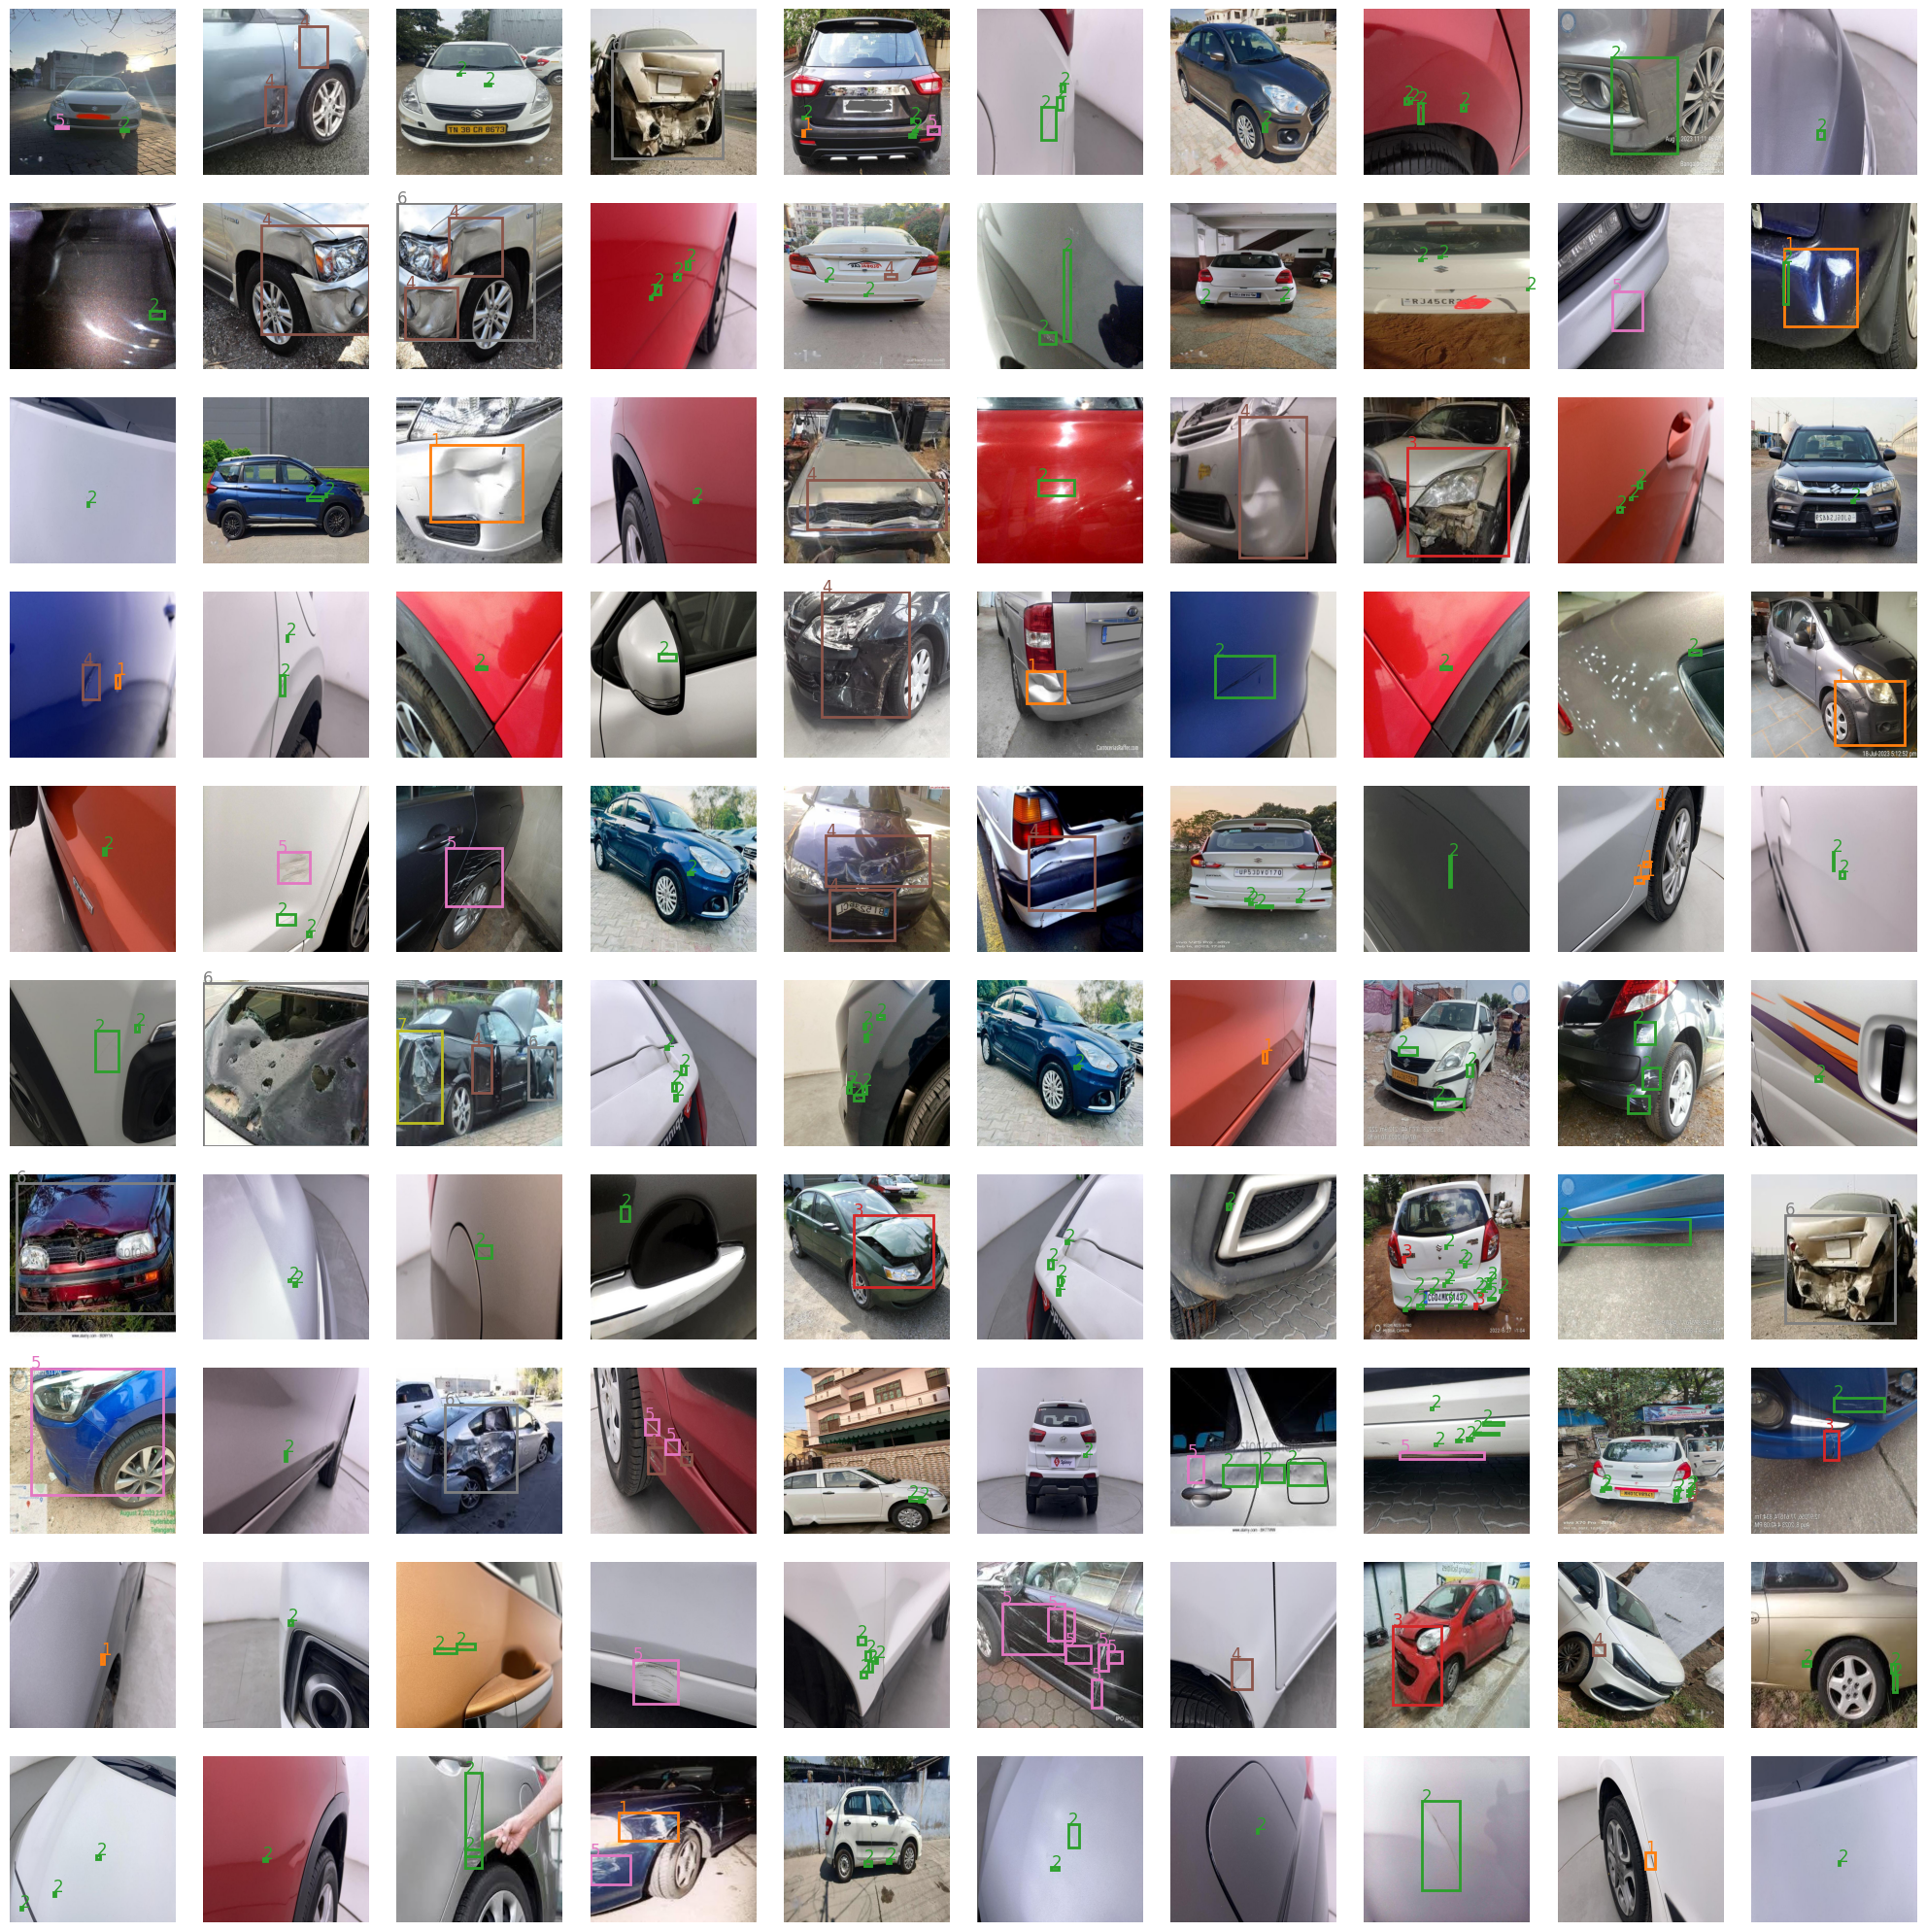

In [4]:
class BreakAllLoops(Exception):
    pass

# Define the main function to process and plot multiple images
def plot_images_with_bboxes(dataloader, num_images=10, rows=2, show_area=False):
    """
    Plots images with bounding boxes in a tileplot.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader containing images and bounding boxes.
        num_images (int): Number of images to plot. Default is 10.
    """
    fig, axes = plt.subplots(rows, num_images//rows, figsize=(20, 20))  # Create a grid of 2 rows x 5 columns
    axes = axes.flatten()

    image_counter = 0
    try:
        for i, (img, target) in enumerate(dataloader):
            for _img, _target in zip(img, target):
                ax = axes[image_counter]
                img_np = _img.permute(1, 2, 0).cpu().numpy()  # Convert to numpy format for plt.imshow
                ax.imshow(img_np)

                # Draw bounding box
                for bbox, label, area in zip(_target['boxes'], _target['labels'], _target['area']):
                    _bbox = bbox.cpu().numpy()
                    rect = patches.Rectangle(
                        (_bbox[0], _bbox[1]), _bbox[2] - _bbox[0], _bbox[3] - _bbox[1],
                        linewidth=2, edgecolor=colors[label.item()], facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(_bbox[0], _bbox[1], label.item(), color=colors[label.item()], fontsize=12)
                    if show_area:
                        ax.text(_bbox[0], _bbox[1] + 20, f'{area:.2f}', color='r', fontsize=12)
                ax.axis('off')  # Turn off axis
                image_counter += 1
                if image_counter >= num_images:
                    raise BreakAllLoops
    except BreakAllLoops:
        pass

    # Remove extra axes if not all are used
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_with_bboxes(data.train_loader, num_images=100, rows=10, show_area=False)


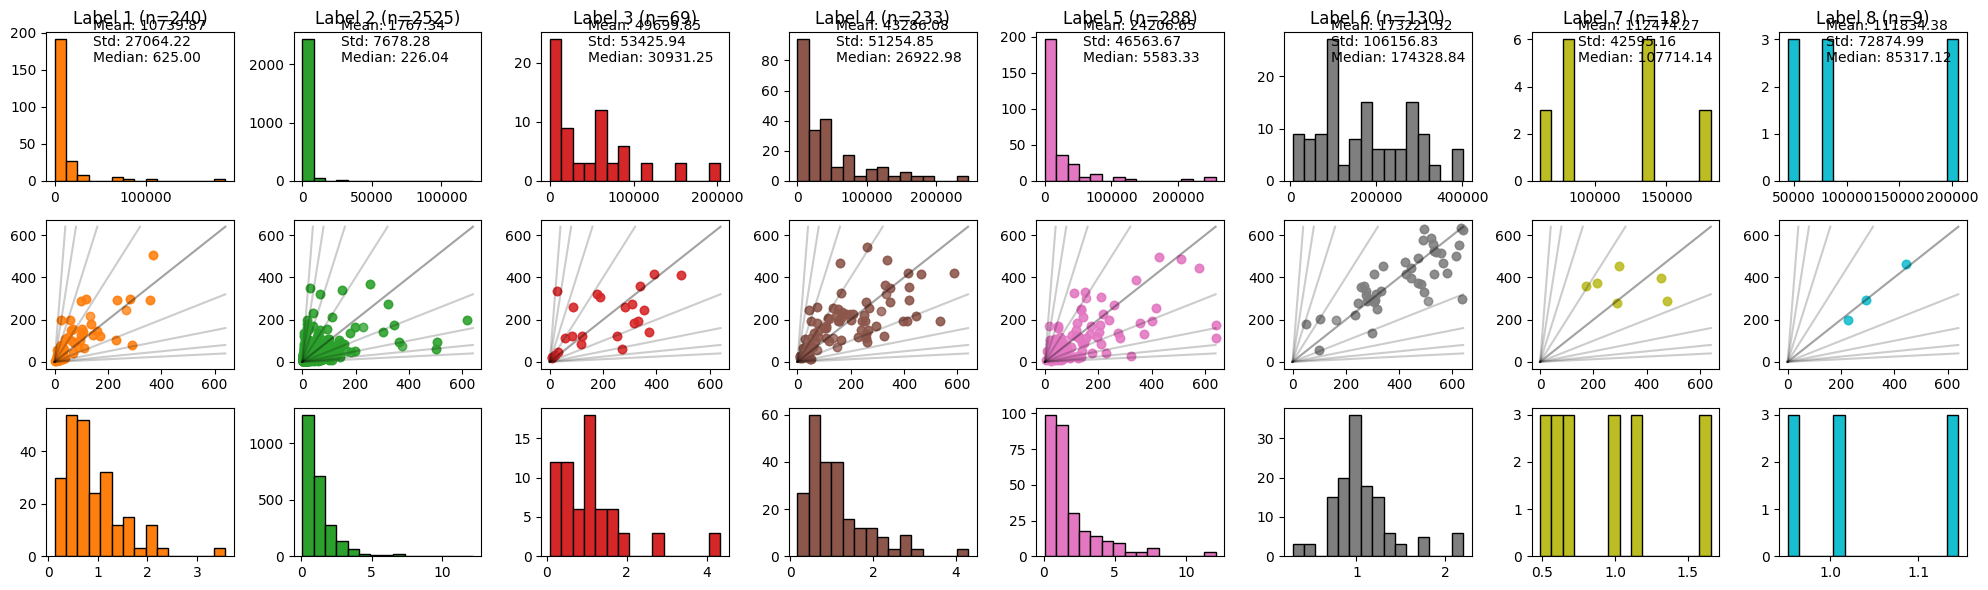

In [9]:
import pandas as pd

def get_annotations(dataloader):
    """
    Get annotations for each image in the dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader containing images and bounding boxes.

    Returns:
        pd.DataFrame: DataFrame containing annotations for each image.
    """
    annotations = []
    for _, target in dataloader:
        for _target in target:
            for label, area, box in zip(_target['labels'], _target['area'], _target['boxes']):
                annotations.append({
                    'label': label.item(),
                    'area': area.item(),
                    'width': box[2].item() - box[0].item(),
                    'height': box[3].item() - box[1].item(),
                })
    return pd.DataFrame(annotations, columns=['label', 'area', 'width', 'height'])

annotations_df = get_annotations(data.train_loader)
# Group by label and plot area distribution per label
labels = sorted(annotations_df['label'].unique())
fig, axes = plt.subplots(3, len(labels), figsize=(20, 6))

ratios = [1, 2, 4, 8, 16]
for i, label in enumerate(labels):
    label_df = annotations_df[annotations_df['label'] == label]
    axes[0][i].hist(label_df['area'], bins=15, edgecolor='black', facecolor=colors[label])
    axes[0][i].set_title(f'Label {label} (n={len(label_df)})')
    axes[0][i].text(0.25, 0.8, f'Mean: {label_df["area"].mean():.2f}\nStd: {label_df["area"].std():.2f}\nMedian: {label_df["area"].median():.2f}', transform=axes[0][i].transAxes)

    for j in ratios:
        axes[1][i].plot([0, 640], [0, 640 / j], color='black', linestyle='-', alpha=0.2)
        axes[1][i].plot([0, 640 / j], [0, 640], color='black', linestyle='-', alpha=0.2)
    
    axes[1][i].scatter(label_df['width'], label_df['height'], color=colors[label], alpha=0.5)
    aspect_ratios = label_df['width'] / label_df['height']
    axes[2][i].hist(aspect_ratios, bins=15, edgecolor='black', facecolor=colors[label])
        
plt.tight_layout()
plt.show()


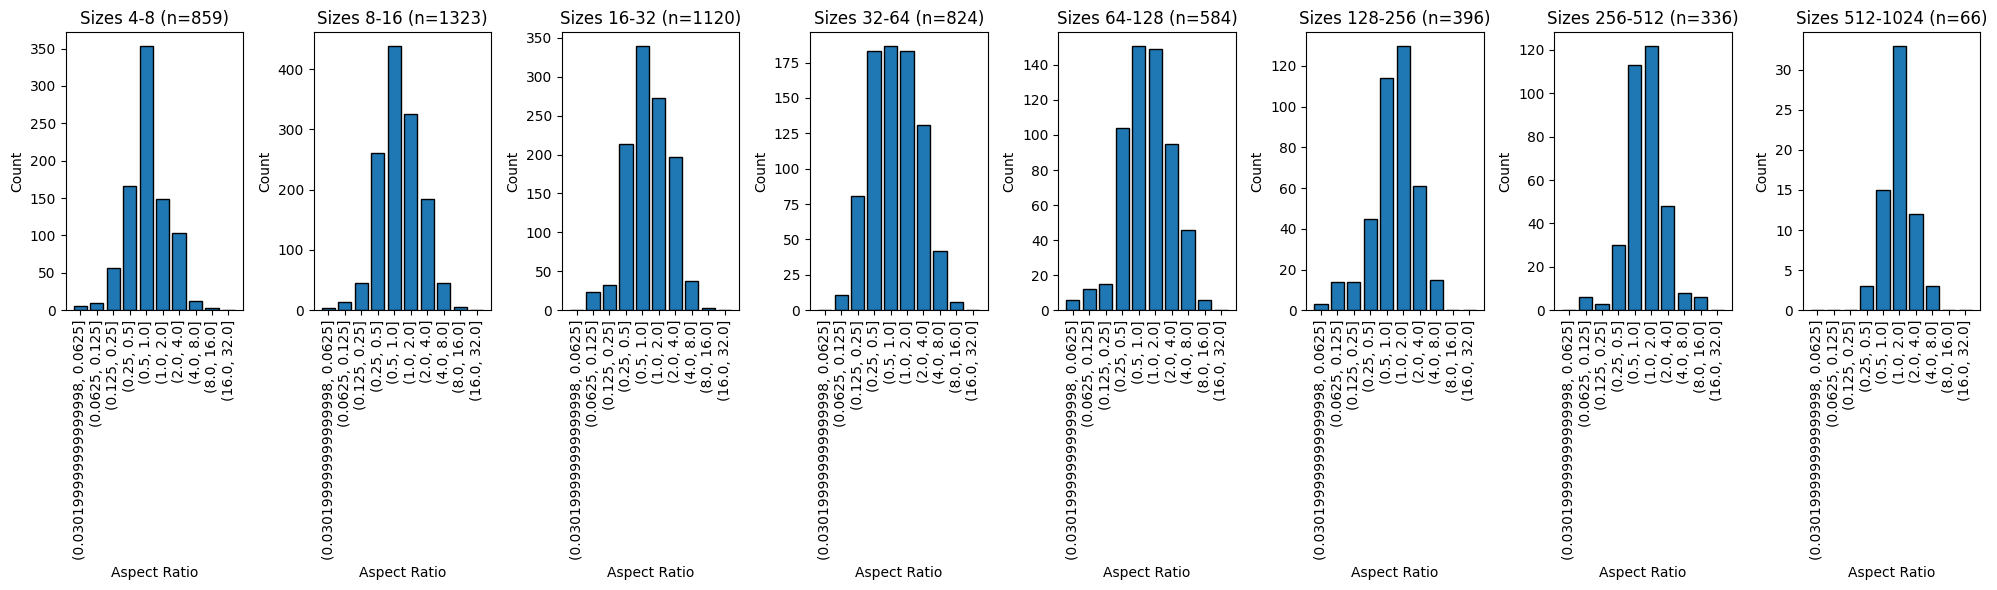

In [10]:
import warnings

warnings.filterwarnings("ignore")

df = get_annotations(data.train_loader)
df['aspect_ratio'] = df['width'] / df['height'] # Calculate aspect ratio
sizes = [4, 8, 16, 32, 64, 128, 256, 512]
ratios = [1, 2, 4, 8, 16, 32]
ratios = sorted(list(set(ratios + [1/i for i in ratios])))
size_bins = {}
for size in sizes:
    size_bins[(size, size*2)] = df[(df['width'] > size) & (df['width'] <= size*2) | (df['height'] > size) & (df['height'] <= size*2)]['aspect_ratio']

fig, axes = plt.subplots(1, len(size_bins), figsize=(20, 6))
count = 0
for i, (size_range, aspect_ratios) in enumerate(size_bins.items()):
    ratio_counts = pd.cut(aspect_ratios, bins=ratios, include_lowest=True).value_counts(sort=False)
    axes[i].bar(ratio_counts.index.astype(str), ratio_counts.values, edgecolor='black')
    axes[i].set_title(f'Sizes {size_range[0]}-{size_range[1]} (n={len(aspect_ratios)})')
    axes[i].set_xlabel('Aspect Ratio')
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(ratio_counts.index.astype(str), rotation=90)
    count += len(aspect_ratios)
plt.tight_layout()
plt.show()
